In [45]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc

In [89]:
adata = sc.datasets.pbmc3k()

In [90]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

### Filter genes

In [91]:
sc.pp.filter_genes(adata,min_counts=100)
sc.pp.filter_genes(adata,max_counts=2000)

In [92]:
adata

AnnData object with n_obs × n_vars = 2700 × 4744
    var: 'gene_ids', 'n_counts'

In [93]:
adata.to_df()

index,NOC2L,HES4,TNFRSF18,TNFRSF4,SDF4,UBE2J2,CPSF3L,AURKAIP1,CCNL2,RP4-758J18.2,...,FAM207A,YBEY,DIP2A,S100B,PRMT2,MT-ND3,MT-ND4L,MT-ND6,AL592183.1,PNRC2-1
index,,,,,,,,,,,,,,,,,,,,,
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
TTTCTACTGAGGCA-1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
TTTCTACTTCCTCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [94]:
arr = np.array(adata.to_df())

In [95]:
import torch
import matplotlib.pyplot as plt

In [109]:
class AE(torch.nn.Module):
    def __init__(self,N):
        super().__init__()
        self.encoder = torch.nn.Sequential(torch.nn.Linear(N,100),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(100,50),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(50,1))
        self.decoder = torch.nn.Sequential(torch.nn.Linear(1,50),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(50,100),
                                           torch.nn.ReLU(),
                                           torch.nn.Linear(100,N))
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return decode

In [110]:
model = AE(adata.n_vars)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
loss_function = torch.nn.MSELoss()
epochs = 10

In [111]:
losses = []
for epoch in range(epochs):
    losses_epoch = []
    for row in arr:
        cell = torch.tensor(row)
        recon = model(torch.tensor(cell))
        loss_epoch = loss_function(recon, cell)
        optimizer.zero_grad()
        loss_epoch.backward()
        optimizer.step()
        losses_epoch.append(loss_epoch.detach().numpy().tolist())
    losses.append(np.average(losses_epoch))
    print("Epoch: " + str(epoch) + " loss: " + str(losses[epoch]))

/var/folders/6p/lpk5hghs3pz6jwr7ngwtcnsw0000gn/T/ipykernel_4942/3776075770.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recon = model(torch.tensor(cell))


Epoch: 0 loss: 0.39603255614431365
Epoch: 1 loss: 0.3886742528307217


KeyboardInterrupt: 

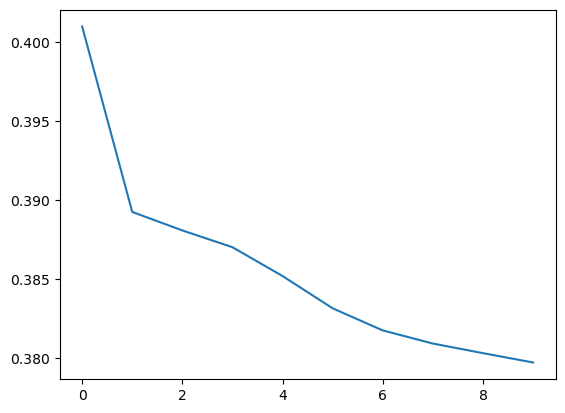

In [99]:
plt.plot(losses)